In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Dense, LSTM
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
import math
import time
import seaborn as sns
sns.set_theme(style="ticks", font='Times New Roman', font_scale=1.4)

# 读取并处理训练数据集

In [10]:
Train_X = np.load('Train_Test_Data/Train_X.npy').reshape((1999, 2))
Train_y = np.load('Train_Test_Data/Train_y.npy').reshape((1999, 1))

In [11]:
scaler_X = MinMaxScaler(feature_range=(0, 1)).fit(Train_X)
Train_X_scaled = scaler_X.transform(Train_X)
scaler_y = MinMaxScaler(feature_range=(0, 1)).fit(Train_y)
Train_y_scaled = scaler_y.transform(Train_y)

In [12]:
# 使x_train符合RNN输入要求：[送入样本数， 循环核时间展开步数， 每个时间步输入特征个数]。
# 此处整个数据集送入，送入样本数为x_train.shape[0]即1999组数据
Train_X_scaled = np.reshape(Train_X_scaled, (Train_X_scaled.shape[0], 1, 2))

In [13]:
Train_y.shape

(1999, 1)

# 划分验证集

In [14]:
# 准备验证集
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

train_windows, test_windows, train_labels, test_labels = make_train_test_splits(Train_X_scaled, Train_y_scaled)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(1599, 400, 1599, 400)

# LSTM设置与训练

In [15]:
model = tf.keras.Sequential([
    LSTM(200, return_sequences=True,input_shape=(Train_X_scaled.shape[1],Train_X_scaled.shape[2])),
    Dropout(0.1),
    LSTM(200),
    Dropout(0.1),
    Dense(1)
])

In [16]:
# Define callbacks.
nb_epoch = 200
reduce_lr_patience = 10
early_stopping_patience = 30

STUDY_NAME_ROOT = 'LSTM_thesis'
TB_LOG_DIR = 'logs/' + STUDY_NAME_ROOT
CHECKPOINT_DIR = 'trained_models/' + STUDY_NAME_ROOT

tensorboard = tf.keras.callbacks.TensorBoard(log_dir=TB_LOG_DIR,
                                                histogram_freq=1)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                            patience=early_stopping_patience,
                                                            verbose=1)
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                            factor=0.5,
                                                            patience=reduce_lr_patience,
                                                            min_lr=1e-10,
                                                            verbose=1)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=CHECKPOINT_DIR,
                                                                save_weights_only=True,
                                                                monitor='val_loss',
                                                                mode='min',
                                                                save_best_only=True)

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(),loss='mean_squared_error')  # Loss MSE

In [18]:
# Fit (and time) LSTM model
t0 = time.time()
history = model.fit(train_windows,
            train_labels,
            epochs=200,
            verbose=0,
            batch_size=64,
            validation_data=(test_windows, test_labels),
            callbacks=[tensorboard,
                                   early_stopping_callback,
                                   reduce_lr_callback,
                                   model_checkpoint_callback])
t1 = time.time()
print('Runtime: %.2f s' %(t1-t0))


Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 38: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 48: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 51: early stopping
Runtime: 13.29 s


# 损失函数曲线

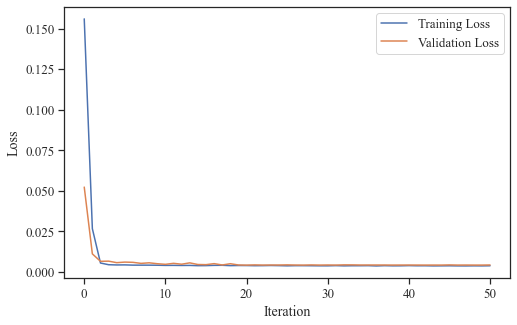

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.rcParams['font.sans-serif']=['Times New Roman']
plt.rcParams['axes.unicode_minus']=False 
plt.figure(figsize=(8,5))
ax = plt.gca()
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Iteration',fontsize=14)
plt.ylabel('Loss',fontsize=14)
plt.savefig('Loss_curve.png',dpi=300,bbox_inches='tight' )

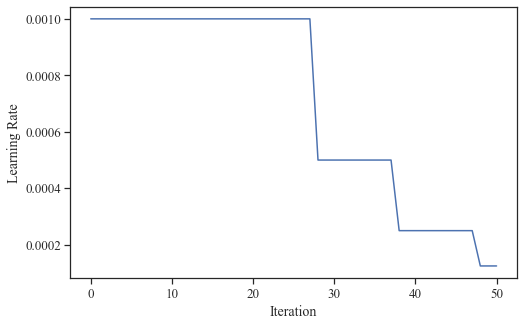

In [35]:
lr=history.history['lr']

plt.rcParams['font.sans-serif']=['Times New Roman']
plt.rcParams['axes.unicode_minus']=False
plt.figure(figsize=(8,5))
ax = plt.gca()
plt.plot(lr)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Iteration',fontsize=14)
plt.ylabel('Learning Rate',fontsize=14)
plt.savefig('Learning_Rate.png',dpi=300,bbox_inches='tight' )

# 模型保存与结构可视化

In [21]:
model.save('LSTM_Model')
print('Model Saved')

INFO:tensorflow:Assets written to: LSTM_Model\assets


INFO:tensorflow:Assets written to: LSTM_Model\assets


Model Saved


In [22]:
model = tf.keras.models.load_model('LSTM_Model')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 200)            162400    
                                                                 
 dropout (Dropout)           (None, 1, 200)            0         
                                                                 
 lstm_1 (LSTM)               (None, 200)               320800    
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 483,401
Trainable params: 483,401
Non-trainable params: 0
_________________________________________________________________


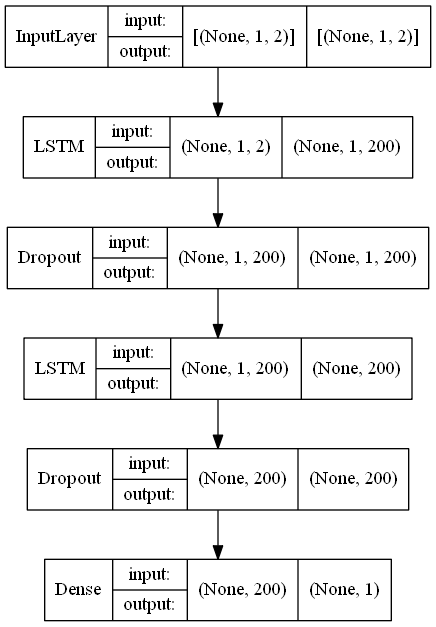

In [24]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes=True,show_layer_names=False,to_file='LSTM_model.png')

# 准确度验证-训练集

In [25]:
def R2_Adj(y,y_pred, n_samples, n_features):
    n, k = n_samples, n_features
    R2 = r2_score(y, y_pred)
    R2_Adj = 1 - (1 - R2) * (n - 1) / (n - k - 1)
    return R2_Adj

In [27]:
# 训练集与验证集的划分
cycle1 = np.linspace(1,1599,1599)
cycle2 = np.linspace(1600,1999,400)

y1 = scaler_y.inverse_transform(train_labels)
y2 = scaler_y.inverse_transform(test_labels )

# 测试集输入模型进行预测
y_pred = model.predict(Train_X_scaled)
# 对预测数据还原---从（0，1）反归一化到原始范围
y_pred = scaler_y.inverse_transform(y_pred)
# 计算真实数据和预测数据之间的R2
score_all = R2_Adj(Train_y.squeeze(),y_pred.squeeze(),y_pred.shape[0],2)

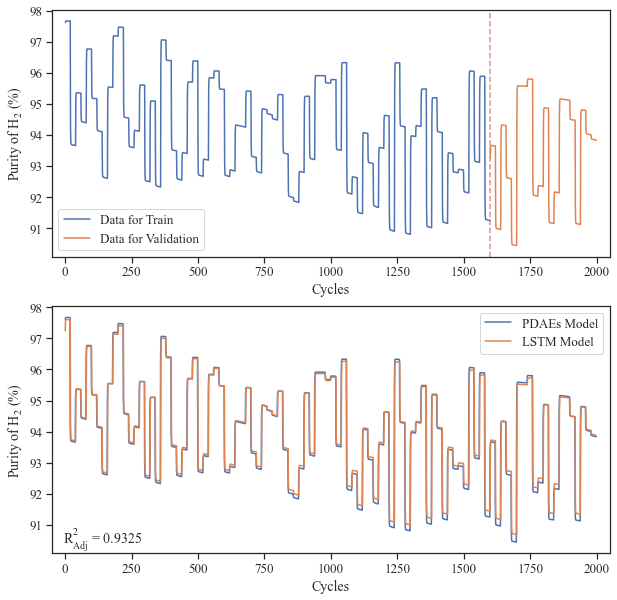

In [28]:
plt.rcParams['font.sans-serif']=['Times New Roman']
plt.rcParams['axes.unicode_minus']=False 

fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,10))
ax1.plot(cycle1,y1,label='Data for Train')
ax1.axvline(1599, color='r',ls="--",lw=1.5,alpha=0.6) # vertical line
ax1.plot(cycle2,y2,label='Data for Validation')
ax1.set_xlabel('Cycles',fontsize=14)
ax1.set_ylabel('Purity of $\mathregular{H_2}$ (%)',fontsize=14)
ax1.tick_params(labelsize='13')
ax1.set_xlim([-50,2050])
ax1.legend(fontsize=13)

ax2.plot(Train_y, label='PDAEs Model')
ax2.plot(y_pred, label='LSTM Model')
ax2.text(0.02,
            0.18,
            '\n$\mathregular{R_{Adj}^2}$' + ' = {:.4f}'.format(score_all),
            ha="left",
            va="top",
            transform=ax2.transAxes,fontsize=14
            )
ax2.set_xlabel('Cycles',fontsize=14)
ax2.set_ylabel('Purity of $\mathregular{H_2}$ (%)',fontsize=14)
ax2.tick_params(labelsize='13')
ax2.set_xlim([-50,2050])
ax2.legend(fontsize=13)

plt.savefig('LSTM_Train_Compare.png',dpi=300,bbox_inches='tight' )

# 准确度验证-测试集

In [30]:
# 测试集
Test_X = np.load('Train_Test_Data/Test_X.npy').reshape((399, 2))
Test_y = np.load('Train_Test_Data/Test_y.npy').reshape((399, 1))
Test_X_scaled = scaler_X.transform(Test_X)
Test_X_scaled = np.reshape(Test_X_scaled, (Test_X_scaled.shape[0], 1, 2))

In [31]:
################## predict ######################
# 测试集输入模型进行预测
predicted_y = model.predict(Test_X_scaled)
# 对预测数据还原---从（0，1）反归一化到原始范围
predicted_y = scaler_y.inverse_transform(predicted_y)
# 计算真实数据和预测数据之间的R2
score = R2_Adj(Test_y,predicted_y,predicted_y.shape[0],2)

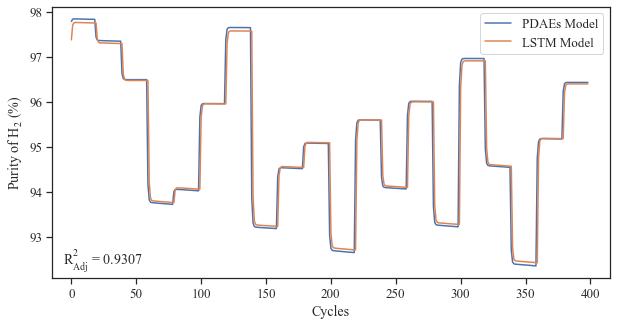

In [32]:
# 画出真实数据和预测数据的对比曲线
plt.rcParams['font.sans-serif']=['Times New Roman']
plt.rcParams['axes.unicode_minus']=False 
plt.figure(figsize=(10,5))
ax = plt.gca()
plt.plot(Test_y, label='PDAEs Model')
plt.plot(predicted_y, label='LSTM Model')
plt.text(0.02,
            0.18,
            '\n$\mathregular{R_{Adj}^2}$' + ' = {:.4f}'.format(score),
            ha="left",
            va="top",
            transform=ax.transAxes,fontsize=14
            )
plt.legend(fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Cycles',fontsize=14)
plt.ylabel('Purity of $\mathregular{H_2}$ (%)',fontsize=14)
plt.xlim(-15,415)
plt.savefig('LSTM_Test_Compare.png',dpi=300,bbox_inches='tight' )

In [33]:
##########evaluate##############
# calculate MSE 均方误差 ---> E[(预测值-真实值)^2] (预测值减真实值求平方后求均值)
mse = mean_squared_error(predicted_y,Test_y)
# calculate RMSE 均方根误差--->sqrt[MSE]    (对均方误差开方)
rmse = math.sqrt(mean_squared_error(predicted_y,Test_y))
# calculate MAE 平均绝对误差----->E[|预测值-真实值|](预测值减真实值求绝对值后求均值）
mae = mean_absolute_error(predicted_y,Test_y)
print('均方误差: %.6f' % mse)
print('均方根误差: %.6f' % rmse)
print('平均绝对误差: %.6f' % mae)

均方误差: 0.179624
均方根误差: 0.423820
平均绝对误差: 0.129908
